In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import pandas as pd
import scipy as sp

from replay_trajectory_classification import (SortedSpikesClassifier,
    SortedSpikesDecoder, Environment, RandomWalk)

import pynapple as nap

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Own modules
from jlab_nwb import JLabNWBHandler
import analyze_one_nwb_settings.import_settings as analyze1_settings
import beh_core_settings.import_settings as beh_import
import Utils.epoch_tools as ep_tools
import Beh.Tracking.tracking_preprocessor as tr_pre

DECODE_DIMS = 2 # 1 for 1D linearized, 2 for 2D using x and y coordinates
# Eric said FR shouldnt matter, but maybe
MAX_FR = 7 # Cells with firing rates above this will be excluded from the decode
MIN_FR = 0.5 # Cells with firing rates below this will be excluded from the decode


import Decode.decode_tools as dec_tools
import Utils.spike_tools as spk_tools

/home/jmolson/miniconda3/envs/SL_Analysis/lib/python3.12/site-packages/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Autoreloader Magic Fns
%load_ext autoreload
%autoreload 1
%aimport StateScriptRecData
%aimport Beh.beh_utilities
%aimport jlab_nwb
%aimport Utils.epoch_tools
%aimport analyze_one_nwb_settings.import_settings
%aimport beh_core_settings.import_settings
%aimport Beh.Tracking.tracking_preprocessor
%aimport Utils.spike_tools
%aimport Decode.decode_tools


In [3]:
# CONSTANTS
BIN_SIZE = 0.002 # for upsampling all data, in seconds. 0.001 is 1 ms, 0.002 is 2 ms, etc
MAX_GAP_SECS = 0.5 # Max gap size to fill during upsampling, in seconds

In [4]:
# Settings Import
# All hard coded values are loaded or defined in import settings
paths, nwb_settings = analyze1_settings.init_analysis()
# Append beh settings to rec settings
beh_settings = beh_import.import_beh_core_settings()
tracking_settings = beh_import.import_tracking_settings()
VEL_THRESH = tracking_settings['track_moving_threshold_cmPerSecs']

# Open NWB
day_rec = JLabNWBHandler(nwb_name=paths['nwb_file'],nwb_path=paths['nwb_path'])

NWB file already exists: /mnt/Fast4TB/DataWorking/SL18_D19/SL18_D19.nwb


In [5]:
# Load data
# Load tracking data
tracking_df = pd.read_pickle(
    os.path.join(paths['beh_path'], paths['nwb_file_stem']
                 + nwb_settings[nwb_settings['fname_tracking_default']]))
# load track graph
tr_graph_file = os.path.join(paths['beh_path'], paths['nwb_file_stem']
                            + nwb_settings['fname_track_graph'])
track_graph, edges, edge_spacing = tr_pre.get_track_map(
    file=os.path.join(tr_graph_file), plot=False)

# Import spikes data as df and TsGroup
nwb_units_df = day_rec.get_spikes() # import
# Convert to pynapple TsGroup
units_tsg = spk_tools.spikes_to_tsg(nwb_units_df)

In [6]:
exp_metadata = day_rec.get_exp_metadata()
epochs_intSet, epochs_df = ep_tools.import_epochs(
    day_rec, beh_settings, nwb_settings)

In [7]:
# Define Training Epochs
epochs_train = epochs_intSet[1]
# epoch_train = epochs_intSet[~epochs_df['is_sleep_epoch']]

In [8]:
# Training Data - Upsampled Position
pos_upsample = dec_tools.upsample_movement(
    tracking_df, dim=1, track_graph_file=tr_graph_file, bin_size=BIN_SIZE,
    time_support=epochs_train, max_gap_secs=MAX_GAP_SECS, plot=False)

In [9]:
pos_upsample

x           y       vel  linear_position
2446.716000        NaN         NaN       NaN              NaN
2446.718000        NaN         NaN       NaN              NaN
2446.720000        NaN         NaN       NaN              NaN
2446.722000        NaN         NaN       NaN              NaN
2446.724000        NaN         NaN       NaN              NaN
...                ...         ...       ...              ...
5232.514233  87.054391  202.352013  1.052973       715.715861
5232.516233  87.054630  202.353142  0.992276       715.716480
5232.518233  87.054816  202.354022  0.943413       715.716961
5232.520233  87.054944  202.354629  0.908626       715.717294
5232.522233  87.055011  202.354943  0.890158       715.717466

[1392903 rows x 4 columns]

In [10]:
# Select subset of units to train on.
units_roi_split = units_tsg.getby_category('region')
print(np.unique(units_tsg.get_info('region')))
units_to_fit = units_roi_split['CA1_L']
print('Whole population is {}'.format(len(units_to_fit)))
# remove units with low spikes and interneurons
units_to_fit = units_to_fit.getby_threshold('rate', MAX_FR, op = '<')
print('Remaining after max threshold: {}'.format(len(units_to_fit)))
units_to_fit = units_to_fit.getby_threshold('rate', MIN_FR, op = '>')
print('Remaining after min threshold: {}'.format(len(units_to_fit)))

['CA1_L' 'CA1_R' 'SUB_L' 'SUB_R']
Whole population is 150
Remaining after max threshold: 145
Remaining after min threshold: 42


In [11]:
# Training Data - Binned Spikes

# Bin centers need to be fed in so that they align perfectly with the
# upsampled position data
bin_centers = pos_upsample.index.values
binned_spikes = spk_tools.bin_spikes(units_to_fit, bin_centers, BIN_SIZE)

In [12]:
# Model Parameters
model_parameters=dict(track_graph_file=tr_graph_file)

In [17]:
my_classifier = dec_tools.Classifier_Model(
    spikes=binned_spikes, position=pos_upsample,
    spikes_test=None, position_test=None, cross_val=0,
    is_training=(pos_upsample['vel']>VEL_THRESH),
    classifier_type='decoder', model_parameters=model_parameters, plot=False
    )

/home/jmolson/miniconda3/envs/SL_Analysis/lib/python3.12/site-packages/replay_trajectory_classification/continuous_state_transitions.py:26: RuntimeWarning: invalid value encountered in divide
  x /= x.sum(axis=1, keepdims=True)
/home/jmolson/miniconda3/envs/SL_Analysis/lib/python3.12/site-packages/replay_trajectory_classification/likelihoods/spiking_likelihood_kde.py:119: RuntimeWarning: divide by zero encountered in log
  return np.exp(np.log(mean_rate) + np.log(marginal_density) - np.log(occupancy))
/home/jmolson/miniconda3/envs/SL_Analysis/lib/python3.12/site-packages/replay_trajectory_classification/likelihoods/spiking_likelihood_kde.py:119: RuntimeWarning: invalid value encountered in subtract
  return np.exp(np.log(mean_rate) + np.log(marginal_density) - np.log(occupancy))


In [74]:
# To list the contents inside objects in Python, you can use the `dir()` function. This function returns a list of the attributes and methods of any object. Additionally, you can use the `vars()` function to get the `__dict__` attribute of an object, which is a dictionary containing the object's attributes.

# Here are some examples:

# 1. **Using `dir()`**:
#     ```python
#     print(dir(my_classifier))
#     ```

# 2. **Using `vars()`**:
#     ```python
#     print(vars(my_classifier))
#     ```

# 3. **Using `__dict__` attribute directly**:
#     ```python
#     print(my_classifier.__dict__)
#     ```

# These methods will help you inspect the contents of your objects.

vars(my_classifier.classifier)
vars(type(my_classifier.classifier.place_fields_[('',0)]))

{'environments': (Environment(environment_name='', place_bin_size=2.0, track_graph=<networkx.classes.graph.Graph object at 0x7f12aab52690>, edge_order=[[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [3, 9], [9, 10], [5, 11], [11, 12], [2, 6], [9, 11]], edge_spacing=[0, 0, 0, 0, 0, 0, 0, 50, 0, 50, 0, 50, 50], is_track_interior=None, position_range=None, infer_track_interior=True, fill_holes=False, dilate=False, bin_count_threshold=0),),
 'observation_models': (ObservationModel(environment_name='', encoding_group=0),
  ObservationModel(environment_name='', encoding_group=0),
  ObservationModel(environment_name='', encoding_group=0)),
 'continuous_transition_types': [[RandomWalk(environment_name='', movement_var=1, movement_mean=0.0, use_diffusion=False),
   Uniform(environment_name='', environment2_name=None),
   Identity(environment_name='')],
  [Uniform(environment_name='', environment2_name=None),
   Uniform(environment_name='', environment2_name=None),
   Uniform(en

In [100]:
my_classifier.classifier.place_fields_[('',0)]

<xarray.DataArray (position: 412, neuron: 42)> Size: 69kB
array([[9.6625394e-05, 1.8872877e-05, 8.7804248e-04, ..., 1.0938572e-03,
        2.5618577e-08, 0.0000000e+00],
       [8.6651205e-05, 2.0770443e-05, 1.0924565e-03, ..., 1.0699104e-03,
        7.3960194e-08, 0.0000000e+00],
       [7.7056684e-05, 2.4668028e-05, 1.3822566e-03, ..., 1.0261897e-03,
        2.0653901e-07, 0.0000000e+00],
       ...,
       [9.1098499e-04, 3.8711853e-05, 6.3060869e-21, ..., 1.2602637e-08,
        2.1367774e-03, 0.0000000e+00],
       [7.1312051e-04, 2.2238088e-05, 3.7967186e-22, ..., 2.8584972e-09,
        2.0318653e-03, 0.0000000e+00],
       [5.5082253e-04, 1.2287692e-05, 2.1910933e-23, ..., 6.2219641e-10,
        1.8735155e-03, 0.0000000e+00]], dtype=float32)
Coordinates:
  * position  (position) float32 2kB 0.9783 2.935 4.892 ... 996.4 998.4 1e+03
Dimensions without coordinates: neuron

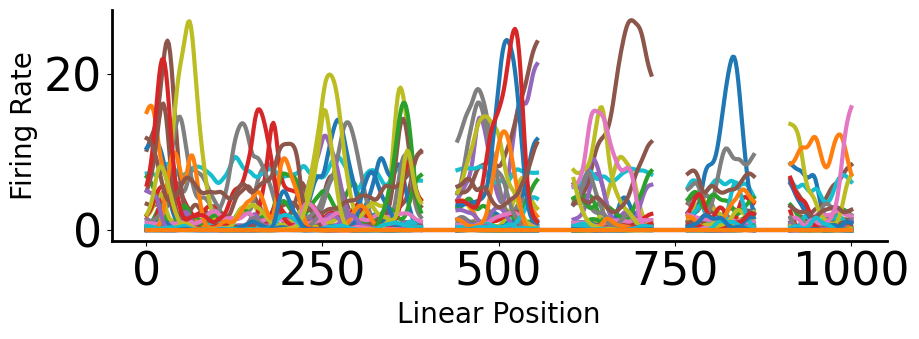

In [99]:
fig, ax = plt.subplots(figsize=(10, 3))
(my_classifier.classifier.place_fields_[('',0)] * int(1 / BIN_SIZE)).plot(
    x="position", hue="neuron", add_legend=False, ax=ax)
ax.set_xlabel('Linear Position')
ax.set_ylabel('Firing Rate')
# ax.set_xlim((0, np.nanmax(pos_upsample['linear_position'])))
sns.despine()

In [63]:
# Testing Spikes and Position
# [len(binned_spikes)/2]
binned_spikes_chunk = binned_spikes[0:int(len(binned_spikes)/2)]
# test_spikes = binned_spikes.loc[:len(binned_spikes)/2]

In [64]:
len(binned_spikes_chunk)

696451

In [66]:
# Run prediction
# Can't do whole session - not enough memory on GPU
# half hour to do half with 40 cells.
classifier_output = my_classifier.predict(binned_spikes=binned_spikes_chunk)

  0%|          | 0/42 [00:00<?, ?it/s]

/home/jmolson/anaconda3/envs/SL_Analysis/lib/python3.12/site-packages/cupy/cuda/compiler.py:233: PerformanceWarning: Jitify is performing a one-time only warm-up to populate the persistent cache, this may take a few seconds and will be improved in a future release...
  jitify._init_module()


In [131]:
print(classifier_output)
print(classifier_output.likelihood.dims)

<xarray.Dataset> Size: 10GB
Dimensions:            (time: 696451, state: 3, position: 412)
Coordinates:
  * time               (time) float64 6MB 2.447e+03 2.447e+03 ... 3.84e+03
  * position           (position) float64 3kB 0.9783 2.935 4.892 ... 998.4 1e+03
  * state              (state) <U10 120B 'continuous' 'fragmented' 'stationary'
Data variables:
    likelihood         (time, state, position) float32 3GB 0.8879 ... 0.9471
    causal_posterior   (time, state, position) float32 3GB 0.0007801 ... 0.00...
    acausal_posterior  (time, state, position) float32 3GB 4.784e-06 ... 0.00...
Attributes:
    data_log_likelihood:  -130233.15
('time', 'state', 'position')


In [171]:
classifier_output.time.values

array([2446.716     , 2446.718     , 2446.72      , ..., 3839.61311666,
       3839.61511666, 3839.61711667])

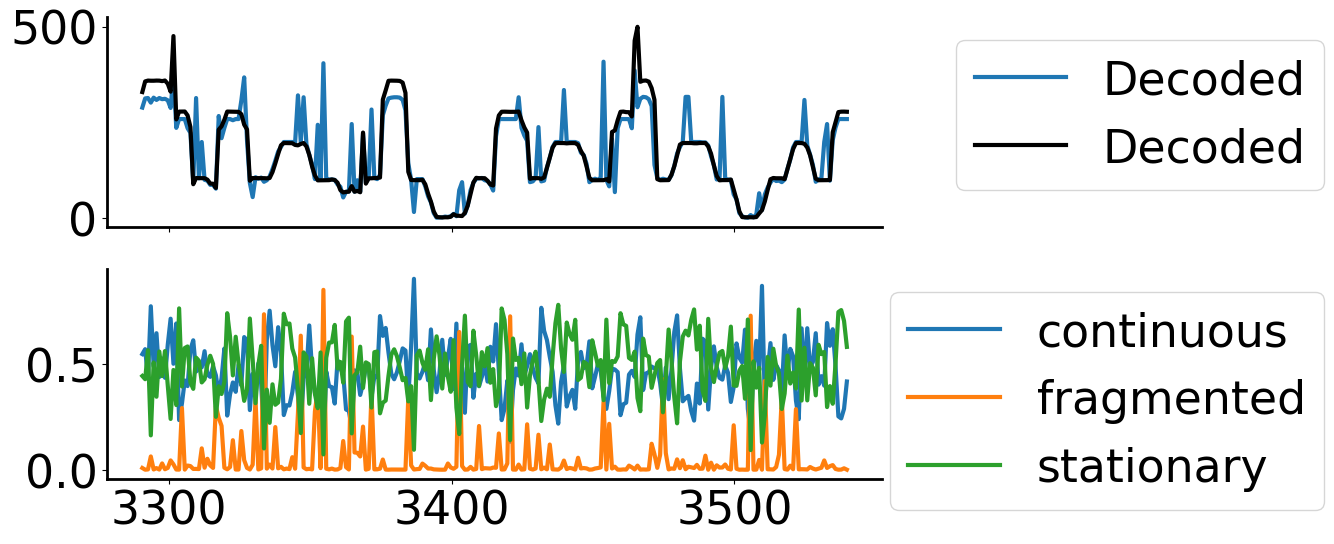

In [203]:
time_ind = 422000
time_int = 500
time_dur = 250
time_end = time_ind+time_dur*time_int

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(10, 6))
real_time = classifier_output.time.values[time_ind:time_end:time_int]
max = classifier_output.acausal_posterior[time_ind:time_end:time_int,:,:].sum('state').argmax(dim='position')
ax1.plot(real_time, max)
ax1.plot(real_time, pos_upsample['linear_position'].iloc[time_ind:time_end:time_int]/2, color='black')
ax1.legend(['Decoded','Decoded','Decoded', 'Actual'], bbox_to_anchor=(1.6,1), loc='upper right')
# plt.plot(classifier_output.acausal_posterior[
#     time_ind:time_ind+time_dur*time_int:time_int,1,:])
# plt.plot(classifier_output.acausal_posterior[
#     time_ind:time_ind+time_dur*time_int:time_int,2,:])

state_prob_output = classifier_output.acausal_posterior.sum('position')
ax2.plot(real_time, state_prob_output[time_ind:time_end:time_int,0])
ax2.plot(real_time, state_prob_output[time_ind:time_end:time_int,1])
ax2.plot(real_time, state_prob_output[time_ind:time_end:time_int,2])
# put legend outside of plot
ax2.legend(classifier_output.state.values, bbox_to_anchor=(1.6,1), loc='upper right')
